# Feature Engineering

In [2]:
# load the packages
import json  
import re
from collections import Counter
import time
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize  
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from textblob import TextBlob
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error as MSE

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

SEED = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load datasets 
ca_path = '/content/drive/My Drive/Data Mining Project/data/CAvideos.csv'
ca = pd.read_csv(ca_path)

gb_path = '/content/drive/My Drive/Data Mining Project/data/GBvideos.csv'
gb = pd.read_csv(gb_path)

us_path = '/content/drive/My Drive/Data Mining Project/data/USvideos.csv'
us = pd.read_csv(us_path)

ca_cat_path = '/content/drive/My Drive/Data Mining Project/data/CA_category_id.json'
ca_cat = pd.read_json(ca_cat_path)

gb_cat_path = '/content/drive/My Drive/Data Mining Project/data/GB_category_id.json'
gb_cat = pd.read_json(gb_cat_path)

us_cat_path = '/content/drive/My Drive/Data Mining Project/data/US_category_id.json'
us_cat = pd.read_json(us_cat_path)

In [0]:
# load the categories data
ca_cat_id = ca_cat['items'].apply(lambda x: x['id'])
ca_cat_name = ca_cat['items'].apply(lambda x: x['snippet']['title'])
ca_cat = pd.DataFrame({'category_id': ca_cat_id, 'category': ca_cat_name})
ca_cat.category_id = ca_cat.category_id.astype('int64')

gb_cat_id = gb_cat['items'].apply(lambda x: x['id'])
gb_cat_name = gb_cat['items'].apply(lambda x: x['snippet']['title'])
gb_cat = pd.DataFrame({'category_id': gb_cat_id, 'category': gb_cat_name})
gb_cat.category_id = gb_cat.category_id.astype('int64')

us_cat_id = us_cat['items'].apply(lambda x: x['id'])
us_cat_name = us_cat['items'].apply(lambda x: x['snippet']['title'])
us_cat = pd.DataFrame({'category_id': us_cat_id, 'category': us_cat_name})
us_cat.category_id = us_cat.category_id.astype('int64')

In [0]:
# merge category names with videos
ca = ca.merge(ca_cat, how = 'left', on = 'category_id')
gb = gb.merge(gb_cat, how = 'left', on = 'category_id')
us = us.merge(us_cat, how = 'left', on = 'category_id')

In [0]:
# convert trending_date and publish_time to datetime datatype
ca.trending_date = pd.to_datetime(ca.trending_date, format = '%y.%d.%m')
ca.publish_time = pd.to_datetime(ca.publish_time)

gb.trending_date = pd.to_datetime(gb.trending_date, format = '%y.%d.%m')
gb.publish_time = pd.to_datetime(gb.publish_time)

us.trending_date = pd.to_datetime(us.trending_date, format = '%y.%d.%m')
us.publish_time = pd.to_datetime(us.publish_time)

In [9]:
# load the brand personality dictionary
bp_path = '/content/drive/My Drive/Data Mining Project/data/Brand Personality.csv'
bp = pd.read_csv(bp_path)
bp.head(10)

Personality               Word
0  COMPETENCE           ABLE (1)
1  COMPETENCE    ABLE_BODIED (1)
2  COMPETENCE          ADEPT (1)
3  COMPETENCE         ADROIT (1)
4  COMPETENCE      ASSIDUOUS (1)
5  COMPETENCE        ASSURED (1)
6  COMPETENCE         ASTUTE (1)
7  COMPETENCE  AWARD_WINNING (1)
8  COMPETENCE       BLOOMING (1)
9  COMPETENCE        BOOMING (1)

In [0]:
bp.Personality.value_counts()

RUGGEDNESS        174
SINCERITY         174
SOPHISTICATION    174
COMPETENCE        168
EXCITEMENT        143
Name: Personality, dtype: int64

In [0]:
# data cleaning for brand personality dictionary
bp.Personality = bp.Personality.str.lower()
bp.Word = bp.Word.apply(lambda x: x[:-4].lower())

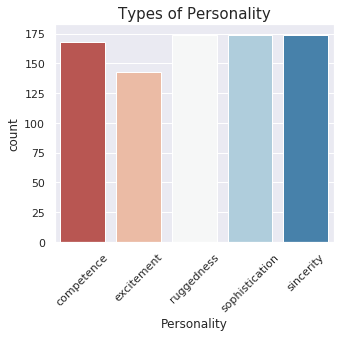

In [0]:
# Visualize the number of trending videos by Country
fig, ax = plt.subplots(figsize=(5, 4))

count = sns.countplot(data = bp, x = 'Personality', palette = 'RdBu')
count.set_xticklabels(count.get_xticklabels(), rotation = 45)
count.set_title('Types of Personality', fontsize = 15)
plt.show()

In [0]:
# merge all the dataframes
ca['country'] = 'CA'
gb['country'] = 'UK'
us['country'] = 'US'

df = ca.append(gb)
df = df.append(us)
df.shape

(120746, 18)

In [0]:
df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'category', 'country'],
      dtype='object')

In [0]:
# Add views_cat column (Popular(1)/Unpopular(0))
quantile = df.views.describe()['75%']
views_cat = pd.DataFrame(df.views.apply(lambda x: 1 if x > quantile else 0))
views_cat.columns = ['views_cat']
df = pd.concat([df, views_cat], axis = 1)
df.shape

(120746, 19)

In [0]:
df.head(3)

video_id trending_date  ... country views_cat
0  n1WpP7iowLc    2017-11-14  ...      CA         1
1  0dBIkQ4Mz1M    2017-11-14  ...      CA         0
2  5qpjK5DgCt4    2017-11-14  ...      CA         1

[3 rows x 19 columns]

## Publish Time

In [0]:
# Add day_of_Week
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_day_of_Week'] = df['publish_time'].apply(lambda time: time.dayofweek)

week_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['publish_day_of_Week'] = df['publish_day_of_Week'].map(week_map)

In [0]:
# get dummies
week_day = pd.get_dummies(df.publish_day_of_Week)
df = pd.concat([df, week_day], axis = 1)

In [0]:
# separates date, hour and time into three columns from 'publish_time' column
df['publish_date'] = pd.to_datetime(df.publish_time.dt.date)
df['publish_hour'] = df.publish_time.dt.hour
df['publish_time'] = df.publish_time.dt.time

In [0]:
# create feature to calculate the number of days between publish date and trending date
df['days_to_trending'] = (df.trending_date - df.publish_date).dt.days

## Video Title

In [0]:
# title character count
df['title_char_length'] = df.title.apply(lambda x: len(x))

In [0]:
# title word count
df['title_word_count'] = df.title.apply(lambda x: len(x.split()))

In [0]:
# contain all capitalized words
def all_cap(x):
    for word in x.split():
        if word.isupper():
            return 1
    return 0

df['title_allcap'] = df.title.apply(all_cap)

In [0]:
# contain question
df['title_question'] = df.title.apply(lambda x: 1 if '?' in x else 0)

## Video Tag

In [0]:
df['tag_nums'] = df.tags.apply(lambda x: len(x.split('|')))

## Description

In [0]:
df.description.head()

0    Eminem's new track Walk on Water ft. Beyoncé i...
1    STill got a lot of packages. Probably will las...
2    WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3    I know it's been a while since we did this sho...
4    🎧: https://ad.gt/yt-perfect\n💰: https://atlant...
Name: description, dtype: object

In [0]:
# create features
df['desc_url'] = df.description.str.contains('http\S+').fillna(0).astype(int)
df['desc_emoji'] = df.description.str.contains('\d+(.*?)[\u263a-\U0001f645]').fillna(0).astype(int)
df['desc_number'] = df.description.str.contains('\d+').fillna(0).astype(int)
df['desc_char_length'] = df.description.apply(lambda x: len(x) if type(x) != float else x)
df['desc_word_count'] = df.description.apply(lambda x: len(x.split()) if type(x) != float else x)

In [0]:
# remove backslash + 1 character
df['desc'] = df.description.str.replace('\\\\.', '', flags=re.MULTILINE)

# remove urls
df.desc = df.desc.str.replace('http\S+', '', flags=re.MULTILINE)

# remove punctuations and emojis
df.desc = df.desc.str.replace('[^\w\s]', '', flags=re.UNICODE)

# remove numbers
df.desc = df.desc.str.replace('\d+', '')

# convert to lower case
df.desc = df.desc.str.lower()

# remove leading and ending spaces
df.desc = df.desc.str.strip()

In [0]:
# tokenization
df['tokenize'] = df.desc.apply(lambda x: [i for i in word_tokenize(x) if not i in stop_words] if type(x) != float else x)

In [0]:
df.tokenize.head(5)

0    [eminems, new, track, walk, water, ft, beyoncé...
1    [still, got, lot, packages, probably, last, an...
2    [watch, previous, video, subscribe, watching, ...
3    [know, since, show, back, might, best, episode...
4    [eds, channel, ed, onfacebook, website, jason,...
Name: tokenize, dtype: object

In [0]:
# stemming
stemmer = PorterStemmer()
df['stemming'] = df.tokenize.apply(lambda x: [stemmer.stem(word) for word in x] if type(x) != float else x)

In [0]:
df.stemming.head(5)

0    [eminem, new, track, walk, water, ft, beyoncé,...
1    [still, got, lot, packag, probabl, last, anoth...
2    [watch, previou, video, subscrib, watch, like,...
3    [know, sinc, show, back, might, best, episod, ...
4    [ed, channel, ed, onfacebook, websit, jason, k...
Name: stemming, dtype: object

In [0]:
# lemmatization
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df.stemming.apply(lambda x: [lemmatizer.lemmatize(word) for word in x] if type(x) != float else x)

In [0]:
df.lemmatized.head(100)

0     [eminem, new, track, walk, water, ft, beyoncé,...
1     [still, got, lot, packag, probabl, last, anoth...
2     [watch, previou, video, subscrib, watch, like,...
3     [know, sinc, show, back, might, best, episod, ...
4     [ed, channel, ed, onfacebook, websit, jason, k...
                            ...                        
95    [关注微信公众号最新独家内容抢先看江苏卫视官方微信jsbcjstv非诚勿扰官方微信jstvf...
96    [negan, father, gabriel, remain, trap, togeth,...
97    [中天的夢想驛站更多影音, 文茜的世界周報週六, 中天的夢想驛站週日, 文茜的世界周報週日,...
98                                                  NaN
99    [le, jeu, de, société, le, jeu, signé, par, to...
Name: lemmatized, Length: 100, dtype: object

In [0]:
# stemming and lemmatizing bp_dict
stemmer = PorterStemmer()
bp['stem'] = bp.Word.apply(lambda x: stemmer.stem(x))
lemmatizer = WordNetLemmatizer()
bp['lemm'] = bp.stem.apply(lambda x: lemmatizer.lemmatize(x))

In [0]:
# transform to a dictionary
bp_dict = dict(zip(bp.lemm, bp.Personality))

In [0]:
# define dict_lookup function
def dict_lookup(x):
  if type(x) != float:
    res = []
    for k, v in bp_dict.items():
      if k in x:
        res.append(v)
    return set(res)
  else:
    return set()

In [0]:
df['bp'] = df.lemmatized.apply(lambda x: dict_lookup(x))

In [0]:
df.bp.head()

0                           {excitement}
1                           {competence}
2                                     {}
3    {competence, excitement, sincerity}
4                           {excitement}
Name: bp, dtype: object

In [0]:
# get dummies
df['competence'] = df.bp.apply(lambda x: 1 if 'competence' in x else 0)
df['excitement'] = df.bp.apply(lambda x: 1 if 'excitement' in x else 0)
df['ruggedness'] = df.bp.apply(lambda x: 1 if 'ruggedness' in x else 0)
df['sincerity'] = df.bp.apply(lambda x: 1 if 'sincerity' in x else 0)
df['sophistication'] = df.bp.apply(lambda x: 1 if 'sophistication' in x else 0)

In [0]:
bp_country = df.groupby('country')['competence', 'excitement', 'ruggedness', 'sincerity', 'sophistication'].sum()
bp_country

competence  excitement  ruggedness  sincerity  sophistication
country                                                               
CA            13291       17558        9075      17005           10541
UK            11758       16962        7182      15009           11527
US            15525       21270       10658      18794           13935

## Add Ratio

In [0]:
# Like-Dislike Ratio 
df['like_dislike_ratio'] = df['likes'] / df['dislikes']

# Like-View Ratio
df['like_view_ratio'] = df['likes'] / df['views']

# Dislike-View Ratio
df['dislike_view_ratio'] = df['dislikes'] / df['views']

# Comment-View Ratio
df['comment_view_ratio'] = df['comment_count'] / df['views']

## Sentiment Analysis on Video Tags

In [0]:
# def nltk_sentiment(text):
#     from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
#     nltk_sentiment = SentimentIntensityAnalyzer()
#     score = nltk_sentiment.polarity_scores(text)
#     return score

Sentiment Analysis on Canada Video Tags

In [0]:
# video_id = pd.DataFrame(ca.video_id)
# ca_tag_tokens = ca.tags.apply(lambda x: x.split('|'))
# nltk_results = [nltk_sentiment(row) for row in ca_tag_tokens]
# results_df = pd.DataFrame(nltk_results)
# results_df = video_id.join(results_df)
# text_df = pd.DataFrame(ca.tags)
# country_df = pd.DataFrame({'country': ['CA']*len(ca)})
# nltk_df = text_df.join(results_df)
# sen_ca_df = country_df.join(nltk_df)

Sentiment Analysis on UK Video Tags

In [0]:
# video_id = pd.DataFrame(gb.video_id)
# gb_tag_tokens = gb.tags.apply(lambda x: x.split('|'))
# nltk_results = [nltk_sentiment(row) for row in gb_tag_tokens]
# results_df = pd.DataFrame(nltk_results)
# results_df = video_id.join(results_df)
# text_df = pd.DataFrame(gb.tags)
# country_df = pd.DataFrame({'country': ['UK']*len(gb)})
# nltk_df = text_df.join(results_df)
# sen_gb_df = country_df.join(nltk_df)

Sentiment Analysis on US Video Tags

In [0]:
# video_id = pd.DataFrame(us.video_id)
# us_tag_tokens = us.tags.apply(lambda x: x.split('|'))
# nltk_results = [nltk_sentiment(row) for row in us_tag_tokens]
# results_df = pd.DataFrame(nltk_results)
# results_df = video_id.join(results_df)
# text_df = pd.DataFrame(us.tags)
# country_df = pd.DataFrame({'country': ['US']*len(us)})
# nltk_df = text_df.join(results_df)
# sen_us_df = country_df.join(nltk_df)

In [0]:
# sen = sen_ca_df.append(sen_gb_df)
# sen = sen.append(sen_us_df)
# sen.head()

In [0]:
# export_csv = sen.to_csv ('/Users/jiaying/Desktop/MScA/Quarter\ 2\ Jan\ 2020\ -\ Mar\ 2020/Data\ Mining/Final\ Project/data/sentiment_tags.csv', 
#                         index = None, header=True)

In [10]:
sa_path = '/content/drive/My Drive/Data Mining Project/data/sentiment_analysis.csv'
sa = pd.read_csv(sa_path)
sa.head()

country                                               tags  ...  pos  compound
0      CA  Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...  ...  0.0    0.0000
1      CA  plush|"bad unboxing"|"unboxing"|"fan mail"|"id...  ...  0.0    0.0000
2      CA  racist superman|"rudy"|"mancuso"|"king"|"bach"...  ...  0.0   -0.6124
3      CA  ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...  ...  0.0    0.0000
4      CA  edsheeran|"ed sheeran"|"acoustic"|"live"|"cove...  ...  0.0    0.0000

[5 rows x 7 columns]

In [0]:
sa_all = sa.drop(['video_id', 'country', 'tags'], axis = 1)

In [0]:
sa_all.head()

neg  neu  pos  compound
0  0.0  1.0  0.0    0.0000
1  0.0  1.0  0.0    0.0000
2  0.2  0.8  0.0   -0.6124
3  0.0  1.0  0.0    0.0000
4  0.0  1.0  0.0    0.0000

Add Positive, Negative, and Neutral Scores to df

In [0]:
# merge with df
df.reset_index(inplace=True, drop=True)
sa_all.reset_index(inplace=True, drop=True)
df_merge = pd.concat([df, sa_all], axis=1)
df_merge.shape

(120746, 58)

In [0]:
df_merge.head(3)

video_id trending_date  ...  pos compound
0  n1WpP7iowLc    2017-11-14  ...  0.0   0.0000
1  0dBIkQ4Mz1M    2017-11-14  ...  0.0   0.0000
2  5qpjK5DgCt4    2017-11-14  ...  0.0  -0.6124

[3 rows x 58 columns]

In [0]:
df_merge.to_csv('/content/drive/My Drive/Data Mining Project/data/df_merge.csv')

In [0]:
df_merge.shape

(120746, 58)

In [0]:
categories = pd.get_dummies(df_merge.category)
df_new = df_merge.join(categories)

countries = pd.get_dummies(df_new.country)
df_new = df_new.join(countries)

In [0]:
df_new.shape

(120746, 78)

In [0]:
df_drop = df_new.drop(['video_id', 'views', 'trending_date', 'title', 'channel_title', 'category_id', \
                          'tags', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'description', \
                          'category', 'country', 'publish_date', 'desc', 'tokenize', 'stemming', \
                          'lemmatized', 'bp', 'like_dislike_ratio', 'like_view_ratio', 'dislike_view_ratio', \
                          'comment_view_ratio', 'days_to_trending'], axis = 1)

In [0]:
df_clean = df_drop.drop(['publish_day_of_Week','publish_time'], axis = 1)

In [0]:
df_clean.shape

(120746, 51)

In [0]:
df_clean.to_csv('/content/drive/My Drive/Data Mining Project/data/df_clean.csv')

## Further Analysis

How many YouTube videos trended in more than 1 country?

In [0]:
ca_video_counts = pd.DataFrame(ca.groupby('video_id').size(), columns = ['CA'])
gb_video_counts = pd.DataFrame(gb.groupby('video_id').size(), columns = ['UK'])
us_video_counts = pd.DataFrame(us.groupby('video_id').size(), columns = ['US'])

video_coexist = ca_video_counts.join(gb_video_counts, how = 'outer')
video_coexist = video_coexist.join(us_video_counts, how = 'outer')
video_coexist = video_coexist.fillna(0)
video_coexist['Total'] = video_coexist.sum(axis = 1)
video_coexist.sort_values(by = 'CA', ascending = False).head()

In [0]:
total_video = video_coexist.shape[0]
trending_more = ((video_coexist == 0).astype(int).sum(axis=1) > 1).sum()
trending_more_pct = round(((video_coexist == 0).astype(int).sum(axis=1) > 1).sum()/total_video*100, 2)
print('Among {} videos, {} ({}%) videos trended in more than 1 country.'.format(total_video, trending_more, trending_more_pct))

Correlation among different countries

It seems like the trending videos from the US and UK have a higher correlation compared to the videos from Canada.

In [0]:
countries = ['CA', 'UK', 'US']
corr_matrix = video_coexist[countries].corr()

plt.figure(figsize = (8, 8))
plt.suptitle('Correlation between Countries', fontsize=15)
heatmap = sns.heatmap(corr_matrix,  cmap = sns.diverging_palette(220, 10, as_cmap = True), square = True, annot = True)

plt.show()